In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [2]:
unemployment = pd.read_csv('Unemployment rate.csv')
unemployment['Monthx'] = pd.to_datetime(unemployment['Month'], format='%b-%y')
unemployment_df = unemployment.set_index('Monthx')
unemployment_df = unemployment_df[['Total']]
unemployment_df.head()

,Total
Monthx,
2000-06-01,4.0
2000-07-01,4.0
2000-08-01,4.1
2000-09-01,3.9
2000-10-01,3.9


In [3]:
gdp = pd.read_csv('US_GDP_quaarterly_growth.csv')
gdp_df = gdp.set_index('U.S. GDP - Historical Data')
gdp_df = gdp_df[['Unnamed: 3']]
gdp_df.drop('Date', inplace=True)
gdp_df.head()
# float(gdp_df['Unnamed: 3'][3][:-1])

,Unnamed: 3
U.S. GDP - Historical Data,
2018-12-01,2.56%
2018-09-01,3.31%
2018-06-01,4.10%
2018-03-01,2.20%
2017-12-01,2.27%


In [4]:
rate = pd.read_csv('fed-funds-rate-historical-chart.csv')
rate_df = rate.set_index('date')
rate_df = rate_df[[' value']].dropna()
rate_df.columns = ['interest_rate']
rate_df.head()

,interest_rate
date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88


In [5]:
inflation = pd.read_csv('US_month_Inflation.csv')
inflation.tail()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AVE
102,2016,1.4,1.0,0.9,1.1,1.0,1.0,0.8,1.1,1.5,1.6,1.7,2.1,1.3
103,2017,2.5,2.7,2.4,2.2,1.9,1.6,1.7,1.9,2.2,2.0,2.2,2.1,2.1
104,2018,2.1,2.2,2.4,2.5,2.8,2.9,2.9,2.7,2.3,2.5,2.2,1.9,2.4
105,2019,1.6,1.5,1.9,2.0,1.8,1.6,1.8,1.7,1.7,1.8,2.1,2.3,1.8
106,2020,2.5,2.3,1.5,0.3,0.1,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# load data
ticker = yf.Ticker('^GSPC')
df_sp500 = ticker.history(period="max", interval='1d')
# df = ticker.history(start="1954-07-10", interval='1d')['Open']
df_sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,0,0,0
1928-01-03,17.76,17.76,17.76,17.76,0,0,0
1928-01-04,17.72,17.72,17.72,17.72,0,0,0
1928-01-05,17.55,17.55,17.55,17.55,0,0,0
1928-01-06,17.66,17.66,17.66,17.66,0,0,0


In [7]:
df_sp500['min-max'] = df_sp500['High'] - df_sp500['Low']
df_sp500['open-close'] = df_sp500['Close'] - df_sp500['Open']
df_sp500 = df_sp500[['Close', 'Volume', 'min-max', 'open-close']]
df_sp500.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,23260.0,4.790389e+02,7.112721e+02,4.40,23.80,99.33,8.131400e+02,3.386150e+03
Volume,23260.0,7.599377e+08,1.475980e+09,0.00,1260000.00,17080000.00,5.182400e+08,1.145623e+10
min-max,23260.0,5.814807e+00,1.108953e+01,0.00,0.00,1.55,6.840000e+00,2.189600e+02
open-close,23260.0,1.017949e-01,8.414116e+00,-150.22,-0.25,0.00,4.500000e-01,1.410300e+02


In [8]:
df = df_sp500.join(rate_df).loc['1954-07-01':]
df = df.loc[:'2020-08-02']
df = df.fillna(method='ffill')
df.isna().sum()

Close            0
Volume           0
min-max          0
open-close       0
interest_rate    0
dtype: int64

In [9]:
# df.head()
df.shape

(16636, 5)

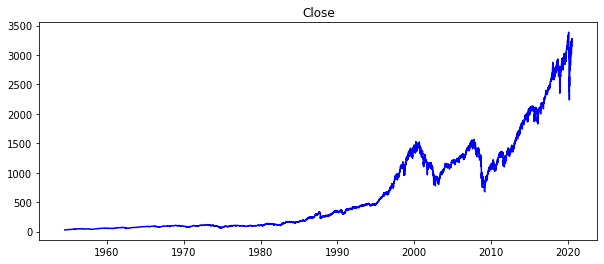

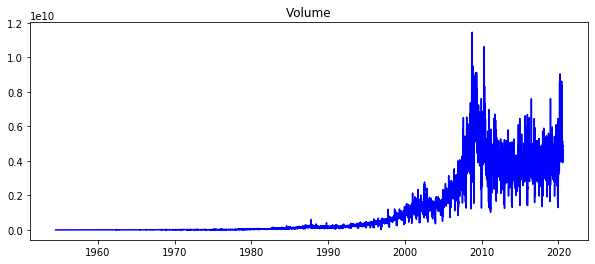

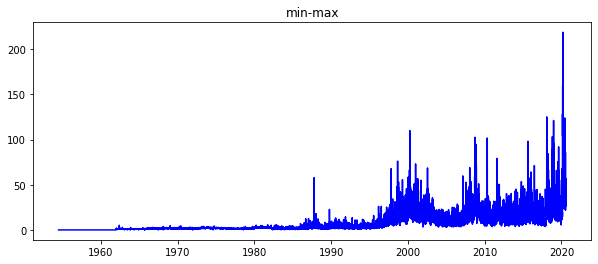

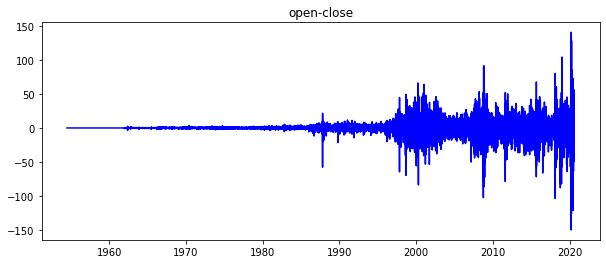

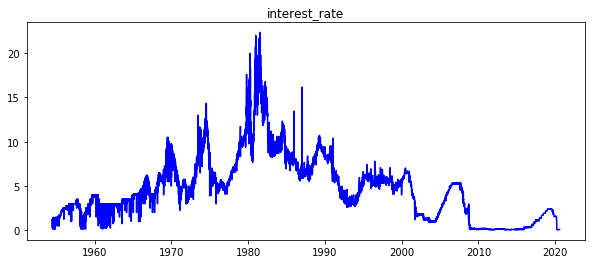

In [10]:
for col in df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df[col], color='blue')
    plt.title(str(col))
    plt.show()

In [11]:
df.corr()

,Close,Volume,min-max,open-close,interest_rate
Close,1.000000,0.795743,0.676108,0.016644,-0.488056
Volume,0.795743,1.000000,0.705070,-0.010458,-0.546688
min-max,0.676108,0.705070,1.000000,-0.086028,-0.336901
open-close,0.016644,-0.010458,-0.086028,1.000000,-0.008149
interest_rate,-0.488056,-0.546688,-0.336901,-0.008149,1.000000


# Multivariate-Multistep Model

In [12]:
from numpy import array

# Reshape from [samples, timesteps] into [samples, timesteps, features]
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import metrics
from tensorflow.keras.backend import clear_session

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [34]:
# model parameters
n_steps_in = 10   # no. of timesteps in the past (for training)
n_steps_out = 1   # no. of timesteps in future (for prediction)
opt = 'adam'      # optimizer function
act = 'tanh'      # activation function
unit = 100
batch = 64
epoc = 50
w = 7             # window size for smoothing the input data
t_size = 90       # size of the test dataset


cols = ['Close', 'Volume', 'min-max', 'open-close', 'interest_rate']  # to keep record of available features!
model = {}
y_pred = {}
i = 0
for w in [1]:
    i += 1
    # select the input dataset
    
    df = df[['Close']]
    
    df_smooth = df.rolling(window=7).mean().dropna()
    data = df_smooth

    # train-test splitting
    train_data = data[:-t_size].values
    test_data = data[-t_size:].values
    
#     scaler = MinMaxScaler()
    scaler = StandardScaler()
    train = scaler.fit_transform(train_data)

    # convert into input/output
    X, y = split_sequences(train, n_steps_in, n_steps_out)
    n_features = X.shape[2]
    
    # define model
    clear_session()
    model[i] = Sequential()
    model[i].add(LSTM(unit, activation=act, input_shape=(n_steps_in, n_features)))
    model[i].add(RepeatVector(n_steps_out))
    model[i].add(LSTM(unit, activation=act, return_sequences=True))
    model[i].add(TimeDistributed(Dense(n_features)))
    model[i].compile(optimizer=opt, loss='mse', metrics=[metrics.mae])

    # fit model
    model[i].fit(X, y, batch_size=batch, epochs=epoc, verbose=1)

    # scale the whole timeseries data
    total_data = data.values
    total_data = scaler.transform(total_data)

    # convert into input/output
    test_size = len(test_data)
    start_index_test = -(test_size + n_steps_in + n_steps_out - 1)
    X_test, y_test = split_sequences(total_data[start_index_test: ], n_steps_in, n_steps_out)

    y_true_smooth = test_data
    y_true = df[-t_size:].values

    # base pred
    y_base_smooth = data.values[-t_size-1:-1]
    y_base_true = df.values[-t_size-1:-1]
    
    # model predict
    y_pred[i] = model[i].predict(X_test)
    for j in range(n_steps_out):
        y_pred[i][:, j, :] = scaler.inverse_transform(y_pred[i][:, j, :])

    # calculate error
    from sklearn.metrics import mean_squared_error
    RMSE = round(np.sqrt(mean_squared_error(y_true[:, 0], y_base_true[:, 0])), 2)
    print('base vs true:', RMSE)
    RMSE = round(np.sqrt(mean_squared_error(y_true[:, 0], y_pred[i][:, 0, 0])), 2)
    print('pred vs true:', RMSE)

Train on 16530 samples
Epoch 1/50
16530/16530 [==============================] - 5s 320us/sample - loss: 0.0408 - mean_absolute_error: 0.0804
Epoch 2/50
16530/16530 [==============================] - 3s 197us/sample - loss: 4.4400e-04 - mean_absolute_error: 0.0115
Epoch 3/50
16530/16530 [==============================] - 3s 189us/sample - loss: 3.9706e-04 - mean_absolute_error: 0.0112
Epoch 4/50
16530/16530 [==============================] - 3s 188us/sample - loss: 3.8699e-04 - mean_absolute_error: 0.0114
Epoch 5/50
16530/16530 [==============================] - 3s 189us/sample - loss: 3.8427e-04 - mean_absolute_error: 0.0115s - loss: 3.8571e-04 - mean_absolute_error: 0.
Epoch 6/50
16530/16530 [==============================] - 3s 189us/sample - loss: 3.0074e-04 - mean_absolute_error: 0.0103s - los
Epoch 7/50
16530/16530 [==============================] - 3s 192us/sample - loss: 2.5289e-04 - mean_absolute_error: 0.0094
Epoch 8/50
16530/16530 [==============================] - 3s 193us/

In [35]:
f = 0  # f is the feature index
for m in model.keys():  # m is the model no.
    RMSE = round(np.sqrt(mean_squared_error(y_true[:, f], y_base_true[:, f])), 2)
    print('base vs true:', RMSE)
    RMSE = round(np.sqrt(mean_squared_error(y_true[:, f], y_pred[m][:, 0, f])), 2)
    print('pred vs true:', RMSE, '\n')

base vs true: 54.07
pred vs true: 78.22 



In [36]:
def long_pred(index, model):
    ar = np.empty((y_true.shape[0]-test_size+index,))
    ar[:] = np.NaN
    return np.concatenate((ar, y_pred[model][index, :, 0]))

p = {}
i = 0
for indx in range(10, 90, 10):
    for m in range(1, len(model)+1):
        i += 1
        p[(indx, m)] = long_pred(indx, m)

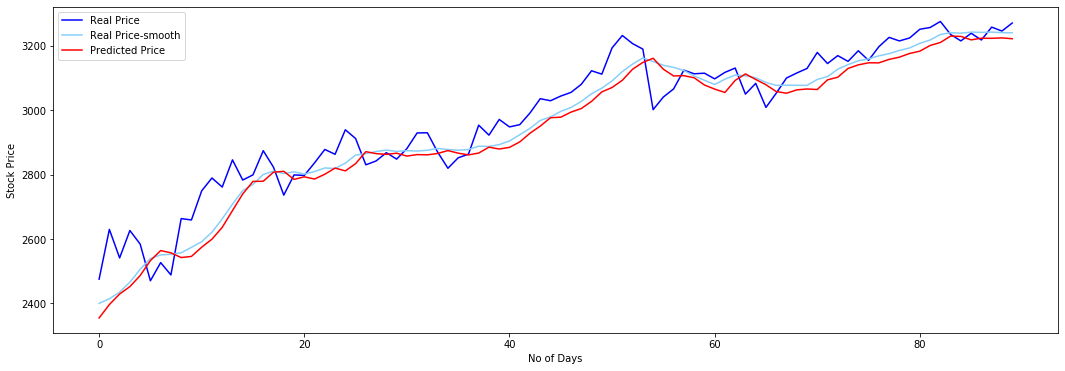

In [37]:
for m in [1]:   # m is the model number
    plt.figure(figsize=(18, 6))
    plt.plot(y_true[:, 0], color='blue', label='Real Price')
    plt.plot(y_true_smooth[:, 0], color='lightskyblue', label='Real Price-smooth')
    plt.plot(y_pred[m][:, 0, 0], color='red', label='Predicted Price')
    for i in list(range(10, 90, 10)):
        plt.plot(p[(i, m)], color='green')
    plt.xlabel('No of Days')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [33]:
# Save model
import joblib
from tensorflow.keras.models import save_model

model_no = 1
model[model_no].save("updated_model_1dPred.h5")
print("Model dumped!")

Model dumped!
